# 分析数据案例

根据病例数据进行制图，并分析历史数据的空间扩散情况
数据来源：
1. https://github.com/yezongyang/china-geojson.git
2. https://gitlab.com/wybert/open-2019-ncov

思路：
1. 读取数据，并对数据的地区进行地理编码处理，使其具有唯一标识，变成点数据
2. 合并数据
3. 制图
4. 批量制图

# 下载地图

## 省份地图

In [1]:
import geopandas as gpd
china = gpd.read_file("china-geojson-master/china.json")

In [2]:
china.head()

,id,size,name,childNum,geometry
0,65,550,新疆维吾尔自治区,18,"POLYGON ((96.41600 42.75880, 96.41600 42.71480..."
1,54,550,西藏自治区,7,"POLYGON ((79.01370 34.32130, 79.10160 34.45310..."
2,15,450,内蒙古自治区,12,"POLYGON ((97.20700 42.80270, 99.49220 42.58300..."
3,63,800,青海省,8,"POLYGON ((89.73630 36.07910, 89.91210 36.07910..."
4,51,900,四川省,21,"POLYGON ((101.77730 33.53030, 101.86520 33.574..."


## 城市地图

In [4]:
import os
import pandas as pd

path = "china-geojson-master\\geometryProvince\\"

provinces_list = []
for fileName in os.listdir(path):
    province_geo = gpd.read_file(path + fileName)
    provinces_list.append(province_geo)
cities = pd.concat(provinces_list,sort=False)

In [5]:
cities.head()

,id,name,cp,childNum,geometry
0,110228,密云区,"[ 117.092300, 40.512100 ]",1.0,"POLYGON ((116.75860 40.70640, 116.78470 40.701..."
1,110116,怀柔区,"[ 116.637700, 40.621900 ]",1.0,"POLYGON ((116.51690 40.57730, 116.52240 40.581..."
2,110111,房山区,"[ 115.845300, 39.716300 ]",1.0,"POLYGON ((115.56930 39.81380, 115.58850 39.813..."
3,110229,延庆区,"[ 116.154300, 40.528600 ]",1.0,"POLYGON ((116.46610 40.77230, 116.48120 40.771..."
4,110109,门头沟区,"[ 115.800000, 39.995700 ]",1.0,"POLYGON ((115.85360 40.14880, 115.86460 40.148..."


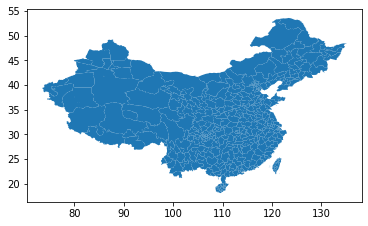

In [8]:
%matplotlib inline
cities.plot();

In [ ]:
cities

# 读取病例数据

## 读取以省份统计的病例数据

In [225]:
import requests
import json
import pandas as pd

url = "http://69.171.70.18:5000/data/province_level_2020-01-25T15.csv"
response = requests.get(url)
province_data = json.loads(response.text)
province_data = pd.DataFrame(province_data)
# province_data.head()

## 读取以城市统计的病例数据

In [226]:
url = "http://69.171.70.18:5000/data/city_level_2020-01-25T15.csv"
response = requests.get(url)
data = json.loads(response.text)
city_data = pd.DataFrame(data)
# city_data.head()

## 地理编码使其变成点数据

### 获取地理编码列表

In [230]:


# geo_map = {}

In [227]:
import json 

with open("geo_map.json","r",encoding = "utf-8") as f:
    mm = f.read()
geo_map = json.loads(mm)

In [229]:
# geo_map

In [1]:
from shapely.geometry import Point
from geopy.geocoders import Baidu
import time


geolocator = Baidu(
            api_key='SjaauTehLOoSmzu8DBGirpWP1xjy3Fwq',#自己修改
           
            timeout=10
        )


# for k,v in city_data.iterrows():
    
#     name = v["city.cityName"]
#     if name in geo_map:
#         continue
        
#     print(name)
#     locator = geolocator.geocode(name,timeout=10)
#     geo_map[name] = (locator.longitude,locator.latitude)
#     time.sleep(1)
#     break

In [17]:
name = "北京"
locator = geolocator.geocode(name,timeout=10)
locator.longitude,locator.latitude

(116.4133836971231, 39.910924547299565)

In [18]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_AWESOME_app_hello_Test")
location = geolocator.geocode("Formosa")
print(location.address)


臺灣


In [139]:
import json
# print(json.dumps(geo_map))
with open("geo_map.json","w",encoding = "utf-8") as f:
    f.write(json.dumps(geo_map,ensure_ascii=False))

### 添加坐标

In [234]:
def get_point_geo(xy):   
    p = Point((*xy))
    return p
city_data.loc[:,"geometry"] = city_data['city.cityName'].map(lambda x: get_point_geo(geo_map[x]))

# 空间叠加

In [233]:
me = gpd.sjoin(cities,city_data)

ValueError: 'right_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

In [232]:
type(city_data)

pandas.core.frame.DataFrame

# 制图

C:\Users\theki\Miniconda3\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\theki\Miniconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


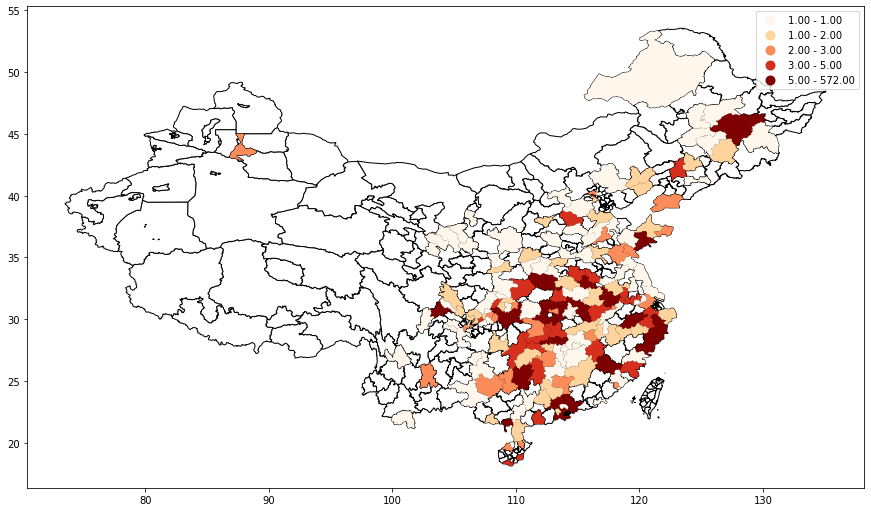

In [222]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1,figsize=(15,15))
# # fig.figsize(15,15)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)

cities.plot(ax=ax,color = "white",edgecolor='black');
me.plot(column='city.confirmedCount', ax=ax, legend=True , cmap='OrRd', scheme='quantiles');

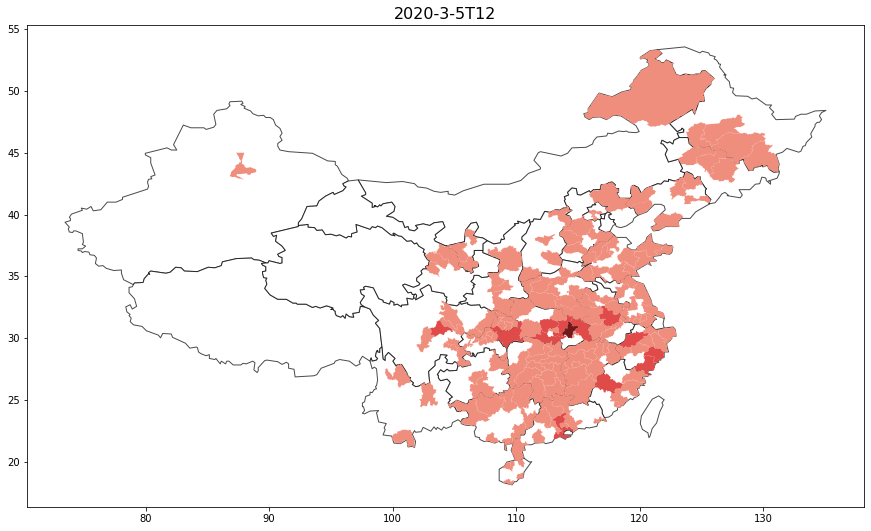

In [224]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1,figsize=(15,15))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)

# cities.plot(ax=ax,color = "white",edgecolor='black',alpha=0.5);
china.plot(ax=ax,color = "white",edgecolor='black',alpha=0.7);
me[me["city.confirmedCount"].map(lambda x: 0<x<10 )].plot( ax=ax,color = "#f08e7e");
me[me["city.confirmedCount"].map(lambda x: x >=10 and x<100 )].plot( ax=ax,color = "#e04b49");
me[me["city.confirmedCount"].map(lambda x: x >=100 )].plot( ax=ax,color = "#73181b");
plt.title("2020-3-5T12", fontsize = 16);

需要按照同一的标准制图
这就需要对其进行颜色设置

# 保存并分享自己的数据

In [11]:
test = gpd.read_file("test.geojson")

In [13]:
test.head()

,id,name,cp,childNum,index_right,Unnamed: 0,city.cityName,city.confirmedCount,city.curedCount,city.deadCount,city.suspectedCount,comment,confirmedCount,curedCount,deadCount,provinceName,provinceShortName,suspectedCount,geometry
0,110114,昌平区,"[ 116.177700, 40.213400 ]",1.0,109,109,昌平,5,0,0,0,None,51,2,0,北京市,北京,0,"POLYGON ((115.96620 40.26560, 115.97720 40.271..."
1,110115,大兴区,"[ 116.471600, 39.635200 ]",1.0,112,112,大兴,2,2,0,0,None,51,2,0,北京市,北京,0,"POLYGON ((116.25180 39.74990, 116.25460 39.763..."
2,110113,顺义区,"[ 116.724200, 40.161900 ]",1.0,114,114,顺义,1,0,0,0,None,51,2,0,北京市,北京,0,"POLYGON ((116.48670 40.12070, 116.48390 40.139..."
3,110108,海淀区,"[ 116.220200, 40.023900 ]",1.0,106,106,海淀,10,0,0,0,None,51,2,0,北京市,北京,0,"POLYGON ((116.04860 40.08710, 116.07190 40.109..."
4,110106,丰台区,"[ 116.268300, 39.830900 ]",1.0,111,111,丰台,3,0,0,0,None,51,2,0,北京市,北京,0,"POLYGON ((116.16940 39.88790, 116.18870 39.881..."
